In [1]:
# Setup: Ensure NLTK and spaCy resources are available
import sys
import subprocess
subprocess.run([sys.executable, '-m', 'pip', 'install', 'nltk', 'spacy'])
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import spacy
subprocess.run([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'])
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Mood Miner – All-in-One Executable Notebook
This notebook builds the emotion classifier and provides a chat interface powered by Gemini API.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Dataset
Place your dataset files (`train.txt`, `val.txt`, `test.txt`) in the `data/` folder. Each file should have two columns: `text` and `emotion`, separated by a tab.

In [3]:
import pandas as pd
import os
def load_txt(path):
    # Each line: <text>;<emotion>
    data = []
    with open(path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if ';' in line:
                text, emotion = line.rsplit(';', 1)
                data.append({'text': text.strip(), 'emotion': emotion.strip()})
    return pd.DataFrame(data)
train_path = os.path.join('data', 'train.txt')
val_path = os.path.join('data', 'val.txt')
test_path = os.path.join('data', 'test.txt')
train_df = load_txt(train_path)
val_df = load_txt(val_path)
test_df = load_txt(test_path)
df = pd.concat([train_df, val_df], ignore_index=True)
print('Train/Val shape:', df.shape)
print('Test shape:', test_df.shape)
df.head()

Train/Val shape: (18967, 2)
Test shape: (2000, 2)


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Preprocessing
Lowercase, remove punctuation, tokenize, remove stopwords, lemmatize.

In [4]:
import string

def preprocess(text):

    text = text.lower()

    text = ''.join([c for c in text if c not in string.punctuation])

    doc = nlp(text)

    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-' and token.lemma_.strip() != '']

    return ' '.join(tokens)


df['clean_text'] = df['text'].apply(preprocess)

test_df['clean_text'] = test_df['text'].apply(preprocess)

print(df[['text', 'clean_text']].head())

print(test_df[['text', 'clean_text']].head())

                                                text  \
0                            i didnt feel humiliated   
1  i can go from feeling so hopeless to so damned...   
2   im grabbing a minute to post i feel greedy wrong   
3  i am ever feeling nostalgic about the fireplac...   
4                               i am feeling grouchy   

                                clean_text  
0                      not feel humiliated  
1  feel hopeless damned hopeful care awake  
2     m grab minute post feel greedy wrong  
3   feel nostalgic fireplace know property  
4                             feel grouchy  
                                                text  \
0  im feeling rather rotten so im not very ambiti...   
1          im updating my blog because i feel shitty   
2  i never make her separate from me because i do...   
3  i left with my bouquet of red and yellow tulip...   
4    i was feeling a little vain when i did this one   

                                          clean_text  
0

## TF-IDF Vectorization
Convert cleaned text to TF-IDF features.

In [5]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])
y = df['emotion']
X_test = vectorizer.transform(test_df['clean_text'])
y_test = test_df['emotion']
print('Train/Val features shape:', X.shape)
print('Test features shape:', X_test.shape)

Train/Val features shape: (18967, 12642)
Test features shape: (2000, 12642)


## Model Training
Train a Logistic Regression classifier.

In [6]:
model = LogisticRegression(max_iter=1000, solver='saga', random_state=42)
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'saga'
,max_iter,1000
,multi_class,'deprecated'


## Evaluation
Check accuracy and confusion matrix.

              precision    recall  f1-score   support

       anger       0.89      0.79      0.83       275
        fear       0.87      0.82      0.85       224
         joy       0.84      0.95      0.89       695
        love       0.82      0.58      0.68       159
     sadness       0.88      0.92      0.90       581
    surprise       0.85      0.52      0.64        66

    accuracy                           0.86      2000
   macro avg       0.86      0.76      0.80      2000
weighted avg       0.86      0.86      0.86      2000



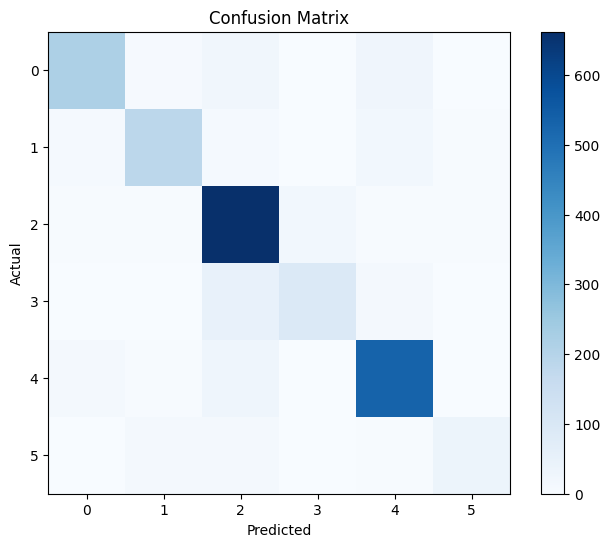

In [21]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
plt.show()

## Save Model
Save trained model and vectorizer for later use.

In [8]:
joblib.dump(model, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

## Final Testing Cell
Test the model on a custom input.

In [20]:
def predict_emotion(text):
    cleaned = preprocess(text)
    print('Preprocessed:', cleaned)
    vect = vectorizer.transform([cleaned])
    probs = model.predict_proba(vect)[0]
    max_prob = np.max(probs)
    threshold = 0.5  # Tune as needed
    if max_prob < threshold:
        return 'neutral'
    return model.classes_[np.argmax(probs)]

sample_text = 'i was in shocked whem i found out that you wre in the hospital'
predicted = predict_emotion(sample_text)
print(f'Predicted emotion: {predicted}')
if predicted == 'neutral':
    print('No strong emotion detected; only echo user query in chat app. All suggestions are generated by LLM.')


Preprocessed: shocked whem find wre hospital
Predicted emotion: surprise
